# Setup

In [2]:
import importlib
import os

import joblib
import pandas as pd

import tlp

url = 'http://konect.cc/files/download.tsv.ca-cit-HepTh.tar.bz2'
dataset_id = '06'
adjusted_intervals = dict()

# Download and extract data

In [5]:
filepath = f'{dataset_id}/edgelist.pkl'
if not os.path.isfile(filepath):
  edgelist = tlp.get_edgelist(url, dataset_id)
  joblib.dump(edgelist, filepath)

# Splitting

In [6]:
%%time
filepath_edgelist = f'{dataset_id}/edgelist.pkl'
filepath_mature = f'{dataset_id}/edgelist_mature.pkl'
filepath_probe = f'{dataset_id}/edgelist_probe.pkl'

if not os.path.isfile(filepath_mature) or not os.path.isfile(filepath_probe):
  edgelist_mature, edgelist_probe = tlp.split_in_intervals(
    edgelist=joblib.load(filepath_edgelist), **adjusted_intervals)
  joblib.dump(edgelist_mature, filepath_mature)
  joblib.dump(edgelist_probe, filepath_probe)

CPU times: user 19.5 ms, sys: 9.95 ms, total: 29.4 ms
Wall time: 113 ms


# Instances

In [7]:
%%time
filepath_mature = f'{dataset_id}/edgelist_mature.pkl'
filepath_instances = f'{dataset_id}/instances.pkl'

if not os.path.isfile(filepath_instances):
  instances = tlp.get_instances(edgelist_mature=joblib.load(filepath_mature),
    verbose=True)
  joblib.dump(instances, filepath_instances)

CPU times: user 24.2 s, sys: 600 ms, total: 24.8 s
Wall time: 24.7 s


# Targets

In [8]:
%%time
filepath_instances = f'{dataset_id}/instances.pkl'
filepath_probe = f'{dataset_id}/edgelist_probe.pkl'
filepath_targets = f'{dataset_id}/targets.pkl'

if not os.path.isfile(filepath_targets):
  targets = tlp.get_targets(
    instances=joblib.load(filepath_instances),
    edgelist_probe=joblib.load(filepath_probe),
    verbose=True)
  joblib.dump(targets, filepath_targets)

Determine targets:   0%|          | 0/2954811 [00:00<?, ?it/s]

CPU times: user 3.95 s, sys: 105 ms, total: 4.05 s
Wall time: 4.03 s


# Sampling

In [9]:
%%time
filepath_instances = f'{dataset_id}/instances.pkl'
filepath_targets = f'{dataset_id}/edgelist_targets.pkl'
filepath_instances_sampled = f'{dataset_id}/instances_sampled.pkl'
filepath_targets_sampled = f'{dataset_id}/targets_sampled.pkl'

if not (os.path.isfile(filepath_instances_sampled) and 
        os.path.isfile(filepath_targets_sampled)):
  instances_sampled, targets_sampled = tlp.balanced_sample(instances, targets)
  joblib.dump(instances_sampled, f'{dataset_id}/instances_sampled.pkl')
  joblib.dump(targets_sampled, f'{dataset_id}/targets_sampled.pkl')

CPU times: user 54.7 ms, sys: 14.6 ms, total: 69.3 ms
Wall time: 128 ms


# Features

## AA (time agnostic)

In [10]:
%%time
filepath = f'{dataset_id}/features'
filepath_mature = f'{dataset_id}/edgelist_mature.pkl'
filepath_instances_sampled = f'{dataset_id}/instances_sampled.pkl'

adamic_adar_time_agnostic = tlp.features.adamic_adar_time_agnostic(
  edgelist=joblib.load(filepath_mature),
  instances=joblib.load(filepath_instances_sampled),
  path=filepath)

CPU times: user 4.98 s, sys: 19.3 ms, total: 5 s
Wall time: 5.02 s


## AA (time aware)

In [11]:
%%time
filepath = f'{dataset_id}/features'
filepath_mature = f'{dataset_id}/edgelist_mature.pkl'
filepath_instances_sampled = f'{dataset_id}/instances_sampled.pkl'

adamic_adar_time_aware = tlp.features.adamic_adar_time_aware(
  edgelist=joblib.load(filepath_mature),
  instances=joblib.load(filepath_instances_sampled),
  path=filepath,
  verbose=True)

time strategies:   0%|          | 0/3 [00:00<?, ?it/s]

aggregation strategies:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?instances/s]

  0%|          | 0/20000 [00:00<?, ?instances/s]

  0%|          | 0/20000 [00:00<?, ?instances/s]

  0%|          | 0/20000 [00:00<?, ?instances/s]

aggregation strategies:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?instances/s]

  0%|          | 0/20000 [00:00<?, ?instances/s]

  0%|          | 0/20000 [00:00<?, ?instances/s]

  0%|          | 0/20000 [00:00<?, ?instances/s]

aggregation strategies:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?instances/s]

  0%|          | 0/20000 [00:00<?, ?instances/s]

  0%|          | 0/20000 [00:00<?, ?instances/s]

  0%|          | 0/20000 [00:00<?, ?instances/s]

CPU times: user 2min 43s, sys: 2.42 s, total: 2min 46s
Wall time: 2min 44s


# Analysis

## Figure: Edge distribution with maturing and probing intervals indicated

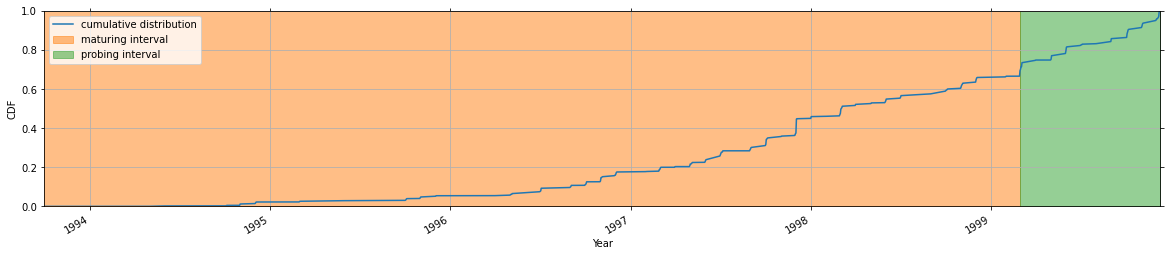

In [12]:
tlp.analysis.plot_datetime(
  joblib.load(f'{dataset_id}/edgelist.pkl')['datetime'], **adjusted_intervals)

## Metric: Class imbalance

In [13]:
tlp.analysis.class_imbalance(targets=joblib.load(f'{dataset_id}/targets.pkl'))

,absolute,relative
False,2935008,0.993298
True,19803,0.006702


## Figure: Datetime strategies

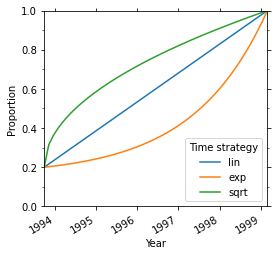

In [14]:
edgelist = joblib.load(f'{dataset_id}/edgelist_mature.pkl')
t = tlp.analysis.plot_datetime_strategies(edgelist['datetime'])

## Figure: Datetime distribution

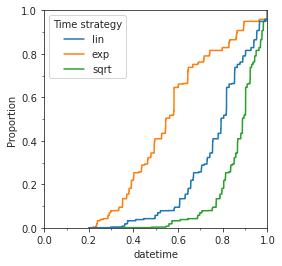

In [15]:
edgelist = joblib.load(f'{dataset_id}/edgelist_mature.pkl')
tlp.analysis.plot_datetime_distribution(edgelist['datetime'])

## Figure: Scores

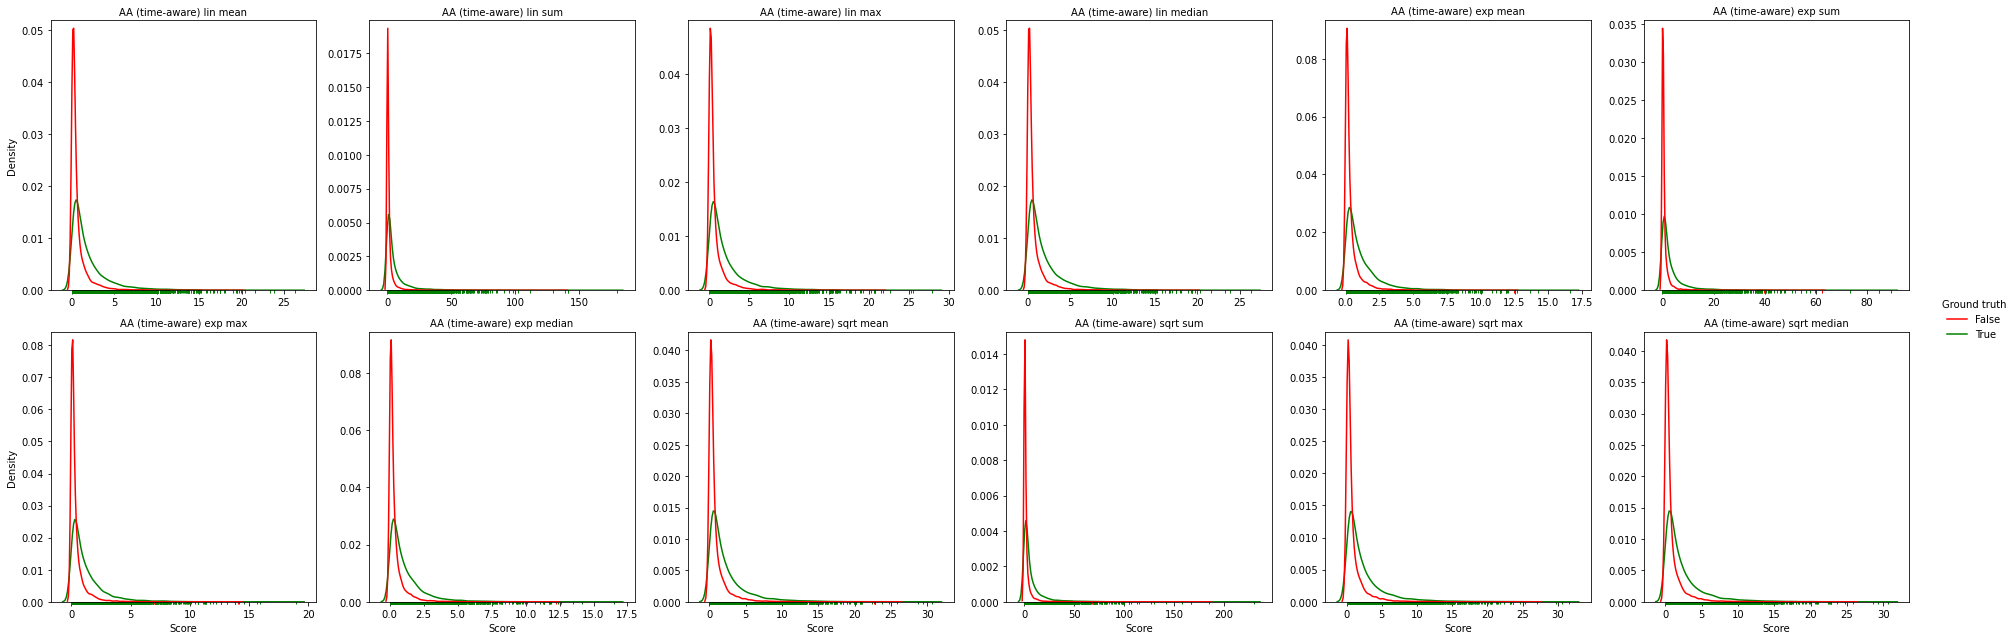

In [16]:
feature_dict = dict()
for file in os.scandir(f'{dataset_id}/features'):
  if file.is_file():
    feature_dict.update(joblib.load(file.path))
targets=joblib.load('01/targets_sampled.pkl')

tlp.analysis.plot_score(feature_dict, targets)

## Figure: ROC

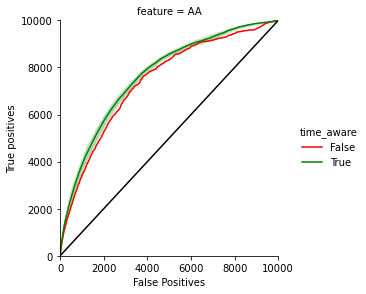

In [3]:
feature_dict = dict()
for file in os.scandir(f'{dataset_id}/features'):
  if file.is_file():
    feature_dict.update(joblib.load(file.path))
targets=joblib.load('01/targets_sampled.pkl')

tlp.analysis.plot_roc_auc(feature_dict, targets)

## AUC

In [4]:
feature_dict = dict()
for file in os.scandir(f'{dataset_id}/features'):
  for file in os.scandir(f'{dataset_id}/features'):
    if file.is_file():
      feature_dict.update(joblib.load(file.path))
targets=joblib.load('01/targets_sampled.pkl')

tlp.analysis.get_auc(feature_dict, targets)

feature  time_aware  aggregation_strategy  time_strategy
AA       False       NaN                   NaN              0.740493
         True        mean                  lin              0.757899
                     sum                   lin              0.773697
                     max                   lin              0.760477
                     median                lin              0.757690
                     mean                  exp              0.770073
                     sum                   exp              0.785406
                     max                   exp              0.774584
                     median                exp              0.769212
                     mean                  sqrt             0.751682
                     sum                   sqrt             0.767908
                     max                   sqrt             0.753256
                     median                sqrt             0.751610
Name: auc, dtype: float64